<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/tutorials/tracking_particle_cnn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Tracking a point particle with a CNN

This tutorial demonstrates how to track a point particle with a convolutional neural network (CNN) using DeepTrack 2.0.

Specifically, this tutotial explains how to: 
* Define the procedure to generate training images
* Extract information from these images to use as labels for the training
* Define and train a neural network model
* Visually evaluate the quality of the neural network output

It is recommended to peruse this tutotial after the [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [1]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider a spherical particle. Specifically, scattering of a spherical particle as determined by mie thery. For this, we use `MieSphere` (see also [scatterers_example](../module-examples/scatterers_example.ipynb)), whose properties are controlled by the following parameters:

* `refractive_index`: The refractive index of the particle

* `radius`: The radius of the marticle

* `position`: The position of the point particle

* `position_unit`: "pixel" or "meter"

In [2]:
mie_particle = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=(32, 32),
    position_unit="pixel",
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Optics` (see also [optics_example](../module-examples/optics_example.ipynb)), which takes a set of particles (light scatterers) and convolves them with the pupil function (point spread function) of the optical system. In this tutorial, there is only one light scatterer (here, `mie_particle`).

The optics is controlled by the following parameters:

* `NA`: The numerical aperature

* `resolution`: The effective camera pixel size (m)

* `magnification`: The magnification of the optical device

* `wavelength`: The wavelength of the lightsource (m)

* `output_region`: The position of the camera and the number of pixels (x, y, width_x, width_y)

* `upscale`: upscales all calculations. Increases accuracy at the cost of speed.

In [3]:
IMAGE_SIZE = 64

brightfield_microscope = dt.Brightfield(
    NA=0.9,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(32, 32, 32, 32),
)

## 4. Create and plot the image

To view some object through an optical device, we call the optical device (here, `brightfield_microscope`) with the object we want to image (here, `point_particle`). This creates a new object (here, `imaged_particle`) that can be used to generate the desired image.

The image is finally generated by calling `imaged_particle.resolve()`.

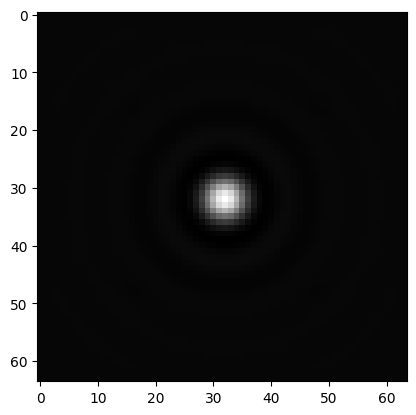

In [4]:
imaged_particle = brightfield_microscope(mie_particle)

output_image = imaged_particle.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

## 5. Randomize the particle position

We can generate particles with random positions by passing to the keyword argument `position` a lambda function that returns a pair of random numbers representing the particle position. We limit the scope, by asserting that the particle is at least 10 pixels from the edge of the image.

We additionally normalize the image to be between 0 and 1. It is very common that normalizing the neural network input improves the results substantially.

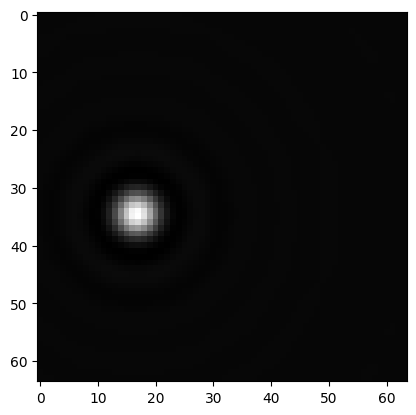

In [5]:
# Generate particle with random position

particle_with_random_position = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=lambda: 10 + np.random.rand(2) * (IMAGE_SIZE - 20),
    position_unit="pixel"
)

imaged_particle_with_random_position = brightfield_microscope(particle_with_random_position)

# Normalize each image between 0 and 1.
normalized_image_of_particle = imaged_particle_with_random_position >> dt.NormalizeMinMax(0, 1) 

output_image = imaged_particle_with_random_position.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')

The position can then be retrieved from the attribute `.position` of the generated image. `.properties` contains a list of all properties used to create the image.

Note that to simulate a particle at a new position, we need to call `.update()`

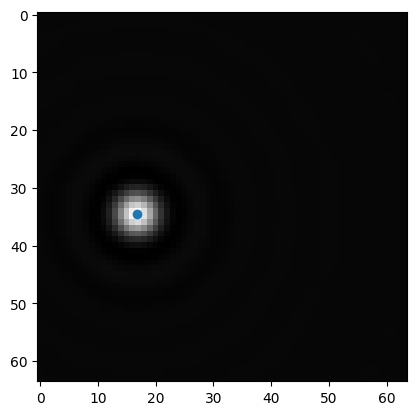

In [6]:


position_of_particle = particle_with_random_position.position()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(position_of_particle[1], position_of_particle[0])
plt.show()

## 6. Define the neural network model

We will use the `deeplay` integration to create a 2d convolutional encoder with a dense top.

The convolutional encoder is defined by the following parameters:
- `in_channels`: The number of input channels.
- `hidden_channels`: The sizes of the hidden layers (list of int).
- `out_channels`: The number of output channels.

The dense top is defined by the following parameters:
- `in_features`: The number of input features (here None, as it is inferred from the encoder).
- `hidden_features`: The sizes of the hidden layers (list of int).
- `out_features`: The number of output features.

We put the encoder and the dense top together in a `Sequential` model.

In [7]:
import deeptrack.deeplay as dl

conv = dl.ConvolutionalEncoder2d(1, [16, 32], 64)
mlp = dl.MultiLayerPerceptron(None, [32], 2)

net = dl.Sequential(
    conv,
    mlp
)

## 7. Define image generator

Generators are objects that feed models with images and their corresponging labels during training. They are as instances of the class `ContinuousGenerator` (see also [generators_example](../module-examples/generators_example.ipynb)). This method takes the following inputs:
* `feature`: A feature (see also [features_example](../module-examples/features_example.ipynb) that resolves images used to train a model (here, `imaged_particle_with_random_position`)
* `label_function`: A function that takes an image as input and returns the label for that image (here, `get_position_of_particle`)
* `batch_size`: The number of images per batch
* `min_data_size` The number of images to create starting training
* `max_data_size` The maximum images to hold in memory at one point in time.

In [8]:
# Function that retireves the position of a particle 
# and divides it by 64 to get values between 0 and 1
scaled_position_of_particle = particle_with_random_position.position / IMAGE_SIZE

image_and_position_pipeline = imaged_particle_with_random_position & scaled_position_of_particle

model = dl.Model(net, 
                 train_data=image_and_position_pipeline,
                 val_data=image_and_position_pipeline,
                 optimizer=dl.Adam(lr=1e-3),
                 loss=dl.torch.nn.L1Loss())

## 8. Train the model

The model is trained by calling the method `.fit()` with the generator we defined in the previous step. Be patient, this might take some time (several minutes).

If you are training on a CPU, consider reducing the number of epochs to around 50.

In [9]:

h = model.fit(max_epochs=100,
          batch_size=32,
          steps_per_epoch=100,
          val_batch_size=256,
          val_steps_per_epoch=1)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ Sequential       │ 23.4 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 23.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_con
nector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_con
nector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the
value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

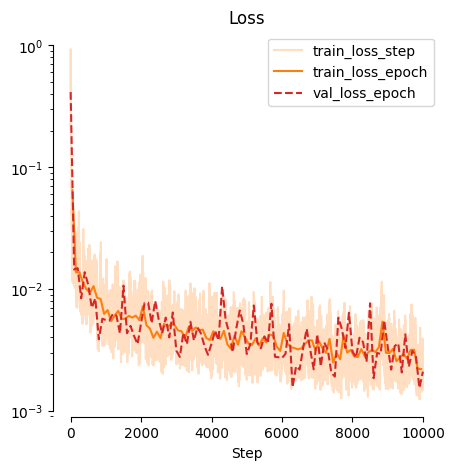

In [11]:
import seaborn as sns

keys = list(h.history.keys())
keys = [key.replace("val", "").replace("train", "") for key in keys]
keys = list(set(keys))

history = h.history
step_history = h.step_history

max_width = 3
rows = len(keys) // max_width + 1
width = min(len(keys), max_width)

fig, axes = plt.subplots(rows, width, figsize=(5 * width, 5 * rows))

if len(keys) == 1:
    axes = np.array([[axes]])

for ax, key in zip(axes.ravel(), keys):
    train_key = "train" + key
    val_key = "val" + key
    step_key = ("train" + key).replace("epoch", "step")

    
    if step_key in step_history:
        ax.plot(step_history[step_key]["step"], step_history[step_key]["value"], label=step_key, color="C1", alpha=0.25)
    if train_key in history:
        step = np.array(history[train_key]["step"])
        step[1:] = step[1:] - (step[1:] - step[:-1]) / 2
        step[0] /= 2
        ax.plot(step, history[train_key]["value"], label=train_key, color="C1")
    if val_key in history:
        ax.plot(history[val_key]["step"], history[val_key]["value"], label=val_key, color="C3", linestyle="--")
    
    ax.set_title(key.replace("_", " ").replace("epoch", "").strip().capitalize())
    ax.set_xlabel("Step")

    ax.legend()
    ax.set_yscale("log")
    sns.despine(ax=ax, trim=True)

## 9. Visualize the model performance

We can now use the trained model to measure the particle position in images previously unseen by the model.

For real applications, it should be noted that the performance can be improved significantly by constraining the particle to be close to the center.

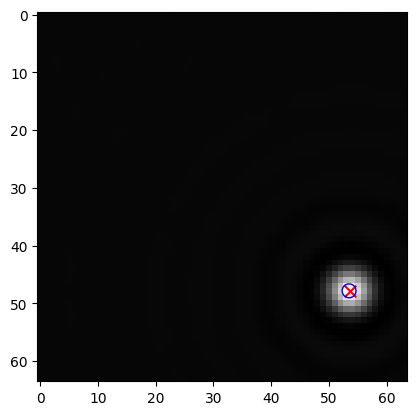

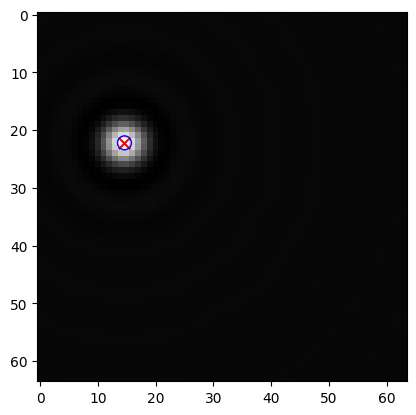

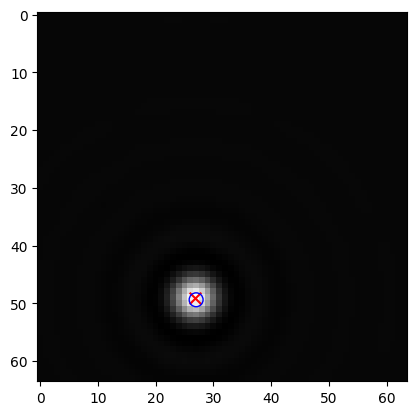

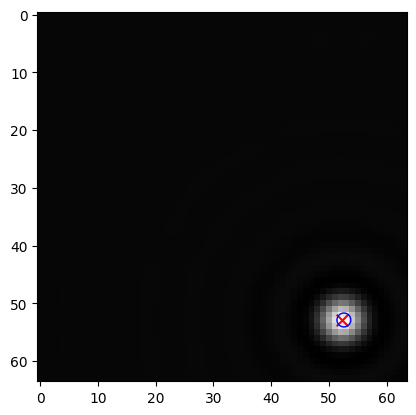

In [12]:

for i in range(4):

    image, true_position = image_and_position_pipeline.update().resolve()
    measured_position = model.predict(image[None].astype(np.float32))
    
    measured_position_x = measured_position[0, 1] * IMAGE_SIZE
    measured_position_y = measured_position[0, 0] * IMAGE_SIZE

    real_position_x = true_position[1] * IMAGE_SIZE
    real_position_y = true_position[0] * IMAGE_SIZE

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()